#### Data Cleaning & Exploration

##### Goal: 
- Load raw CSVs from Phase 1
- Align dates and merge BTC + ETH datasets
- Handle missing values and inconsistencies
- Perform basic Exploratory Data Analysis (EDA)
- Prepare a combined clean dataset for metrics & analysis

Focus timeframe: 2024-01-01 to Feb 2026

#### Imports & Setup

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Nicer plots – use a modern Seaborn-compatible style
%matplotlib inline
plt.style.use('seaborn-v0_8-darkgrid')   # or 'seaborn-v0_8-whitegrid' / 'seaborn-v0_8'
pd.set_option('display.max_columns', 15)
pd.set_option('display.float_format', '{:,.2f}'.format)

#### 2. Load the Data

In [7]:
# Load BTC (from Blockchain.com on-chain + price)
btc_price = pd.read_csv('btc_price_volume_2024_2026.csv', 
                        parse_dates=['date'], 
                        index_col='date')

# Load ETH (from Binance/ccxt — our main source)
eth_df = pd.read_csv('eth_binance_2024_2026.csv', 
                     parse_dates=['date'], 
                     index_col='date')

print("BTC shape:", btc_price.shape)
print("ETH shape:", eth_df.shape)
print("\nBTC index range:", btc_price.index.min(), "to", btc_price.index.max())
print("ETH index range:", eth_df.index.min(), "to", eth_df.index.max())

BTC shape: (778, 6)
ETH shape: (778, 2)

BTC index range: 2024-01-01 00:00:00 to 2026-02-16 00:00:00
ETH index range: 2024-01-01 00:00:00 to 2026-02-16 00:00:00


In [5]:
eth_df.head(3)

,price_usd,trading_volume
date,,
2024-01-01,"2,352.04","216,702.69"
2024-01-02,"2,355.34","458,041.66"
2024-01-03,"2,209.72","798,729.49"


In [6]:
btc_price.head(3)

,timestamp,open,high,low,close,volume
date,,,,,,
2024-01-01,1704067200000,"42,283.58","44,184.10","42,180.77","44,179.55","27,174.30"
2024-01-02,1704153600000,"44,179.55","45,879.63","44,148.34","44,946.91","65,146.41"
2024-01-03,1704240000000,"44,946.91","45,500.00","40,750.00","42,845.23","81,194.55"


#### 3. Standardize Column Names & Filter Timeframe

In [8]:
# Rename for clarity and consistency
btc_df = btc_price.rename(columns={
    'close': 'btc_price_usd',
    'volume': 'btc_volume'
})[['btc_price_usd', 'btc_volume']]

eth_df = eth_df.rename(columns={
    'price_usd': 'eth_price_usd',
    'trading_volume': 'eth_volume'
})[['eth_price_usd', 'eth_volume']]

# Filter to common date range (2024 onwards)
start_date = '2024-01-01'
end_date = datetime.now().strftime('%Y-%m-%d')   # or hardcode '2026-02-16'

btc_df = btc_df.loc[start_date:end_date]
eth_df = eth_df.loc[start_date:end_date]

print("Filtered BTC shape:", btc_df.shape)
print("Filtered ETH shape:", eth_df.shape)

Filtered BTC shape: (778, 2)
Filtered ETH shape: (778, 2)


#### 4. Merge BTC + ETH on Date Index

In [9]:
# Outer merge to keep all dates, then inspect misses
combined = btc_df.join(eth_df, how='outer')

print("Combined shape:", combined.shape)
print("\nMissing values count:\n", combined.isna().sum())

# Forward-fill small gaps (common in weekends/holidays for crypto — but rare on Binance)
combined = combined.fillna(method='ffill')

# If still NaNs at beginning → drop or backfill (usually just first row)
combined = combined.dropna()   # safe for now, since crypto data is near-complete

print("\nAfter cleaning - Missing values:\n", combined.isna().sum())
combined.head()

Combined shape: (778, 4)

Missing values count:
 btc_price_usd    0
btc_volume       0
eth_price_usd    0
eth_volume       0
dtype: int64

After cleaning - Missing values:
 btc_price_usd    0
btc_volume       0
eth_price_usd    0
eth_volume       0
dtype: int64


C:\Users\Eldu\AppData\Local\Temp\ipykernel_4860\983110019.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  combined = combined.fillna(method='ffill')


,btc_price_usd,btc_volume,eth_price_usd,eth_volume
date,,,,
2024-01-01,"44,179.55","27,174.30","2,352.04","216,702.69"
2024-01-02,"44,946.91","65,146.41","2,355.34","458,041.66"
2024-01-03,"42,845.23","81,194.55","2,209.72","798,729.49"
2024-01-04,"44,151.10","48,038.06","2,267.11","448,844.05"
2024-01-05,"44,145.11","48,075.25","2,268.78","405,568.00"


#### 5. Basic EDA – Visual & Statistical

##### 1. Price trends side-by-side

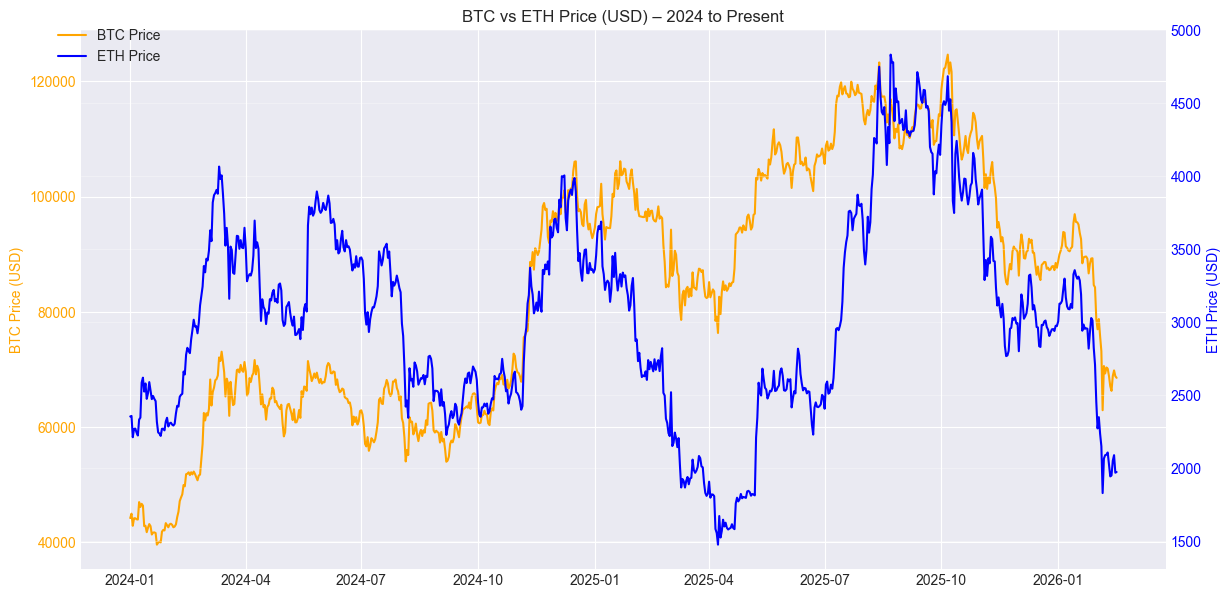

In [10]:
fig, ax1 = plt.subplots(figsize=(14, 7))

ax1.plot(combined.index, combined['btc_price_usd'], color='orange', label='BTC Price')
ax1.set_ylabel('BTC Price (USD)', color='orange')
ax1.tick_params(axis='y', labelcolor='orange')

ax2 = ax1.twinx()
ax2.plot(combined.index, combined['eth_price_usd'], color='blue', label='ETH Price')
ax2.set_ylabel('ETH Price (USD)', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

plt.title('BTC vs ETH Price (USD) – 2024 to Present')
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))
plt.grid(True, alpha=0.3)
plt.show()

##### 2. Volume comparison (log scale often better for crypto)

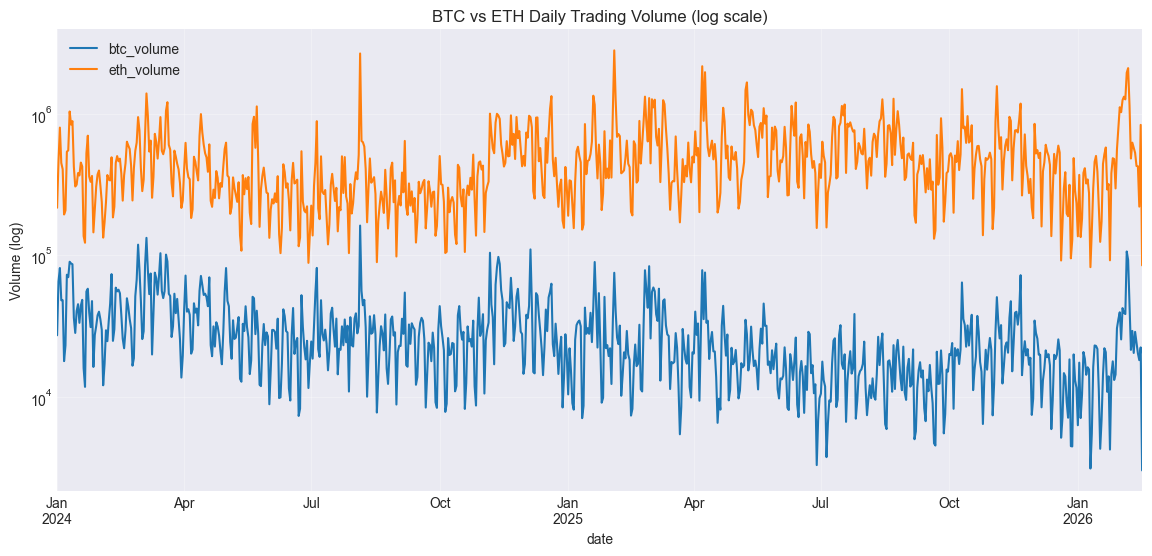

In [11]:
combined[['btc_volume', 'eth_volume']].plot(figsize=(14, 6), logy=True)
plt.title('BTC vs ETH Daily Trading Volume (log scale)')
plt.ylabel('Volume (log)')
plt.grid(True, alpha=0.3)
plt.show()

##### 3. Correlation matrix

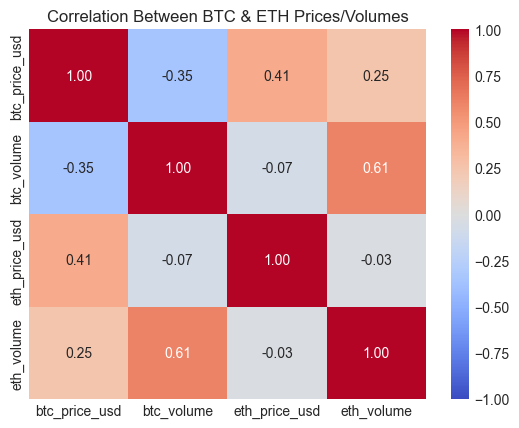

In [12]:
corr = combined.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt='.2f')
plt.title('Correlation Between BTC & ETH Prices/Volumes')
plt.show()

##### 4. Basic stats

In [13]:
print("\nDescriptive Statistics:\n")
print(combined.describe())


Descriptive Statistics:

       btc_price_usd  btc_volume  eth_price_usd   eth_volume
count         778.00      778.00         778.00       778.00
mean       83,769.67   27,903.90       3,036.15   493,212.79
std        21,710.37   19,291.02         704.76   316,944.54
min        39,568.02    3,010.97       1,473.41    82,341.05
25%        64,949.46   15,166.91       2,519.24   281,989.18
50%        86,877.55   23,130.17       3,020.40   421,946.26
75%       102,572.39   34,501.69       3,497.25   607,555.14
max       124,658.54  162,065.59       4,832.07 2,807,979.02


##### 5. Returns (daily % change) – useful for later analysis

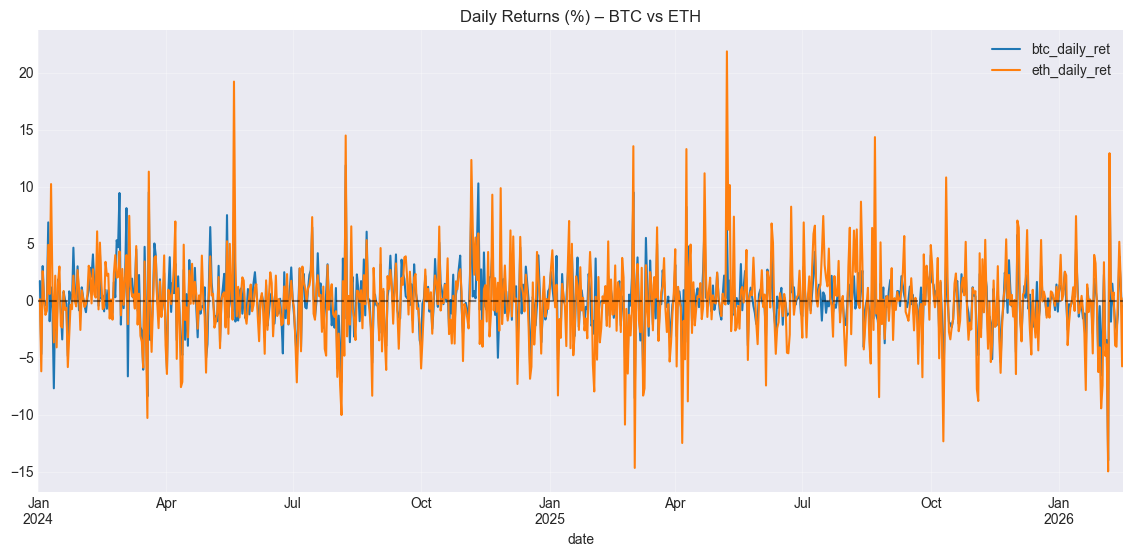

In [14]:
combined['btc_daily_ret'] = combined['btc_price_usd'].pct_change() * 100
combined['eth_daily_ret'] = combined['eth_price_usd'].pct_change() * 100

combined[['btc_daily_ret', 'eth_daily_ret']].plot(figsize=(14, 6), title='Daily Returns (%) – BTC vs ETH')
plt.axhline(0, color='black', linestyle='--', alpha=0.5)
plt.grid(True, alpha=0.3)
plt.show()

##### 5. Save Cleaned Dataset

In [15]:
combined.to_csv('combined_btc_eth_clean_2024_current.csv')

print("Cleaned dataset saved. Ready for Phase 3: Metrics Calculation & Analysis.")
combined.tail(5)

Cleaned dataset saved. Ready for Phase 3: Metrics Calculation & Analysis.


,btc_price_usd,btc_volume,eth_price_usd,eth_volume,btc_daily_ret,eth_daily_ret
date,,,,,,
2026-02-12,"66,272.17","24,271.74","1,947.85","427,567.15",-1.21,0.34
2026-02-13,"68,853.96","20,244.55","2,048.72","425,649.77",3.90,5.18
2026-02-14,"69,822.95","18,114.78","2,086.59","220,677.24",1.41,1.85
2026-02-15,"68,832.58","22,290.05","1,966.58","834,778.10",-1.42,-5.75
2026-02-16,"68,531.68","3,010.97","1,971.25","84,828.70",-0.44,0.24
